### Import Libraries

In [79]:
#Libs
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.manifold import Isomap
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans

### Import Data

In [36]:
#data
dim_cd_df = pd.read_csv('../data/interim_data/dim_cd_df.csv',index_col=0)
dim_qq_df = pd.read_csv('../data/interim_data/dim_qq_df.csv',index_col=0)
FACT_df = pd.read_csv('../data/interim_data/FACT_df.csv',index_col=0)

### Subset and Merge Data

In [37]:
#Subset the Fact table for only data from the US for 2020 and remove rows where the answer was NA
us_data = pd.merge(FACT_df,dim_cd_df[['Account_Num','Country','geometry']],on='Account_Num')

us_data.drop_duplicates(inplace=True)
us_data=us_data.query("Country == 'United States of America' & Year ==2020 & Answer != 'Question not applicable'")
us_data.head()

Account_Num  Year  Question_ID  \
24989        10495  2020         8044   
24992        10495  2020         8044   
24995        10495  2020         8044   
24998        10495  2020         8044   
25001        10495  2020         8044   

                                                  Answer  \
24989  Ecosystem preservation and biodiversity improv...   
24992                            Disaster Risk Reduction   
24995                                Enhanced resilience   
24998                 Enhanced climate change adaptation   
25001                              Disaster preparedness   

                        Country                 geometry  
24989  United States of America  POINT (-115.14 36.1699)  
24992  United States of America  POINT (-115.14 36.1699)  
24995  United States of America  POINT (-115.14 36.1699)  
24998  United States of America  POINT (-115.14 36.1699)  
25001  United States of America  POINT (-115.14 36.1699)

In [38]:
#merge with dim_qq_df for the question section
us_data = pd.merge(us_data,dim_qq_df[['Question_ID','Sect']],on='Question_ID')

In [39]:
#sample 5000 rows
us_data_sample = us_data.sample(5000).reset_index(drop=True)
us_data_sample.shape

(5000, 7)

### spaCy

In [40]:

#!pip install spaCy           --install packages
#!python -m spacy download en_core_web_md    #--download english model

In [41]:
import spacy

#use the medium sized model for vectorization
nlp = spacy.load("en_core_web_md")

In [42]:
#generate a corpus of answers
docs = list(nlp.pipe(us_data_sample.Answer))

In [43]:
def extract_tokens_plus_meta(doc:spacy.tokens.doc.Doc):
    """Extract tokens and metadata from individual spaCy doc."""
    return [
        (i.text, i.i, i.lemma_.lower(), i.ent_type_, i.tag_, 
         i.dep_, i.pos_, i.is_stop, i.is_alpha, 
         i.is_digit, i.is_punct) for i in doc
    ]

In [44]:
def tidy_tokens(docs):
    """Extract tokens and metadata from list of spaCy docs."""
    
    cols = [
        "doc_id", "token", "token_order", "lemma", 
        "ent_type", "tag", "dep", "pos", "is_stop", 
        "is_alpha", "is_digit", "is_punct"
    ]
    
    meta_df = []
    for ix, doc in enumerate(docs):
        meta = extract_tokens_plus_meta(doc)
        meta = pd.DataFrame(meta)
        meta.columns = cols[1:]
        meta = meta.assign(doc_id = ix).loc[:, cols]
        meta_df.append(meta)
        
    return pd.concat(meta_df).reset_index(drop=True)

In [45]:
#create a new table of our answers broken down by spaCy attributes
tidy_doc = tidy_tokens(docs)

In [46]:
tidy_doc.head()

doc_id      token  token_order      lemma ent_type  tag    dep    pos  \
0       0        Yes            0        yes            UH   ROOT   INTJ   
1       1  Awareness            0  awareness            NN  nsubj   NOUN   
2       1    raising            1      raise           VBG   ROOT   VERB   
3       1    program            2    program            NN   dobj   NOUN   
4       1         or            3         or            CC     cc  CCONJ   

   is_stop  is_alpha  is_digit  is_punct  
0    False      True     False     False  
1    False      True     False     False  
2    False      True     False     False  
3    False      True     False     False  
4     True      True     False     False

In [47]:
#Add an index to our US data
us_data_sample=us_data_sample.reset_index()

In [48]:
#merge to add question id and geometry
df_merge = pd.merge(tidy_doc,us_data_sample[['index','Sect','geometry']], 
                    left_on ='doc_id',right_on='index')
#drop the duplicate column 
df_merge.drop(columns='index',inplace=True)

#reorder
df_merge=df_merge[['Sect','doc_id','geometry',
                   'token','token_order','lemma',
                   'ent_type','tag','dep',
                   'pos','is_stop','is_alpha',
                   'is_digit','is_punct']]

In [49]:
#Now we can sort by Question ID
df_merge.sort_values(['Sect','doc_id','token_order']).head()

Sect  doc_id                 geometry      token  \
1  Adaptation Actions       1  POINT (-85.6784 38.196)  Awareness   
2  Adaptation Actions       1  POINT (-85.6784 38.196)    raising   
3  Adaptation Actions       1  POINT (-85.6784 38.196)    program   
4  Adaptation Actions       1  POINT (-85.6784 38.196)         or   
5  Adaptation Actions       1  POINT (-85.6784 38.196)   campaign   

   token_order      lemma ent_type  tag    dep    pos  is_stop  is_alpha  \
1            0  awareness            NN  nsubj   NOUN    False      True   
2            1      raise           VBG   ROOT   VERB    False      True   
3            2    program            NN   dobj   NOUN    False      True   
4            3         or            CC     cc  CCONJ     True      True   
5            4   campaign            NN   conj   NOUN    False      True   

   is_digit  is_punct  
1     False     False  
2     False     False  
3     False     False  
4     False     False  
5     False     False

In [50]:
#lets investigate the POS of SPACE
#this will take the spaces and place the "prevous and next tokens" around the space. 
(df_merge
 .groupby("doc_id")
 .apply(lambda x: x.assign(
     prev_token = lambda x: x.token.shift(1), 
     next_token = lambda x: x.token.shift(-1))
       )
 .reset_index(drop=True)
 .query("pos == 'SPACE'")
 .loc[:, ["doc_id", "prev_token", "token", "next_token"]]
).head()

doc_id prev_token token   next_token
485       73          ,            Oakland
656       88          .                The
669       88          ,        illuminates
834       90          .                  •
1126     106          .          Establish

In [51]:
#pull out an example text. You can see the extra space between "traveled,  and transition"
list(us_data_sample.loc[us_data_sample.index==111].Answer)

['Extreme hot temperature > Extreme hot days']

We can see from investigating doc number, the space is just a typo error of an additional space

In [52]:
#Subset DF to remove stopwords, punctuation and SPACE p.o.s
df_merge_simplified=df_merge.query("is_stop == False & is_punct == False & pos != 'SPACE'")
df_merge_simplified

Sect  doc_id  \
0                                Climate Hazards       0   
1                             Adaptation Actions       1   
2                             Adaptation Actions       1   
3                             Adaptation Actions       1   
5                             Adaptation Actions       1   
...                                          ...     ...   
56630                               Water Supply    4997   
56632                           Adaptation Goals    4998   
56633  Climate Risk and Vulnerability Assessment    4999   
56634  Climate Risk and Vulnerability Assessment    4999   
56635  Climate Risk and Vulnerability Assessment    4999   

                       geometry       token  token_order       lemma ent_type  \
0      POINT (-80.1918 25.7617)         Yes            0         yes            
1       POINT (-85.6784 38.196)   Awareness            0   awareness            
2       POINT (-85.6784 38.196)     raising            1       raise            
3       POINT (-85.6784 38.196)     program            2     program            
5       POINT (-85.6784 38.196)    campaign            4    campaign            
...                         ...         ...          ...         ...      ...   
56630  POINT (-77.0075 38.9779)    supplies            5      supply            
56632  POINT (-82.9988 39.9612)        2025            0        2025     DATE   
56633  POINT (-122.332 47.6062)    Relevant            0    relevant            
56634  POINT (-122.332 47.6062)        city            1        city            
56635  POINT (-122.332 47.6062)  department            2  department            

       tag       dep   pos  is_stop  is_alpha  is_digit  is_punct  
0       UH      ROOT  INTJ    False      True     False     False  
1       NN     nsubj  NOUN    False      True     False     False  
2      VBG      ROOT  VERB    False      True     False     False  
3       NN      dobj  NOUN    False      True     False     False  
5       NN      conj  NOUN    False      True     False     False  
...    ...       ...   ...      ...       ...       ...       ...  
56630  NNS      pobj  NOUN    False      True     False     False  
56632   CD      ROOT   NUM    False     False      True     False  
56633   JJ      amod   ADJ    False      True     False     False  
56634   NN  compound  NOUN    False      True     False     False  
56635   NN      ROOT  NOUN    False      True     False     False  

[34013 rows x 14 columns]

### Text Exploration

In [53]:
#How many unique sectors are there?
len(df_merge_simplified.Sect.unique())

33

In [54]:
#unique lemma per sector
unique_lemma = df_merge_simplified.groupby('Sect')['lemma'].nunique().sort_values(ascending=False)
unique_lemma.head(10)

Sect
Mitigation Actions                    1511
Climate Hazards                       1498
Adaptation Actions                    1257
Governance                             726
Introduction                           636
Collaboration                          628
Adaptation Planning                    599
Opportunities                          565
Finance and Economic Opportunities     545
Water Supply Management                519
Name: lemma, dtype: int64

In [55]:
#number of different doc_id per group
unique_doc_id = df_merge_simplified.groupby('Sect')['doc_id'].nunique().sort_values(ascending=False)
unique_doc_id

Sect
Climate Hazards                                   1054
Mitigation Actions                                 637
Adaptation Actions                                 585
City-wide GHG Emissions Data                       477
Energy                                             233
GCoM Emission Factor and Activity Data             211
Climate Risk and Vulnerability Assessment          155
Adaptation Planning                                152
Mitigation Target setting                          144
Mitigation Planning                                125
Finance and Economic Opportunities                 124
Adaptation Goals                                   120
Transport                                          116
Water Supply Management                             96
Historical emissions inventories                    88
Collaboration                                       85
City Details                                        78
Governance                                          73
Water

Intersting to see the few responses for sectors such as urban planning, data management, and adaptation planning processes. We will subset these values for sectors with more than 20 responses

In [56]:
unique_doc_id = unique_doc_id.loc[unique_doc_id.values > 20].sort_values(ascending=False)
unique_doc_id.head(10)

Sect
Climate Hazards                              1054
Mitigation Actions                            637
Adaptation Actions                            585
City-wide GHG Emissions Data                  477
Energy                                        233
GCoM Emission Factor and Activity Data        211
Climate Risk and Vulnerability Assessment     155
Adaptation Planning                           152
Mitigation Target setting                     144
Mitigation Planning                           125
Name: doc_id, dtype: int64

In [57]:
#The average number of unique Lemma per answer
words_per_id = unique_lemma/unique_doc_id
words_per_id = (words_per_id.loc[words_per_id.notnull()].sort_values(ascending=False)).astype('int')
words_per_id.head(10)

Sect
Governance                            9
Opportunities                         8
Collaboration                         7
Waste                                 6
Food                                  6
Water Supply Management               5
Finance and Economic Opportunities    4
Adaptation Planning                   3
Water Supply                          3
Adaptation Goals                      2
dtype: int64

In [58]:
#subset our data to important features
data_sect_id_pos_lemma =df_merge_simplified[['Sect','doc_id','pos','lemma']]\
                        .sort_values(['Sect','doc_id','pos'])
data_sect_id_pos_lemma

Sect  doc_id    pos       lemma
1           Adaptation Actions       1   NOUN   awareness
3           Adaptation Actions       1   NOUN     program
5           Adaptation Actions       1   NOUN    campaign
2           Adaptation Actions       1   VERB       raise
14          Adaptation Actions       7   NOUN  resilience
...                        ...     ...    ...         ...
56517  Water Supply Management    4975  PROPN       water
56519  Water Supply Management    4975  PROPN  wastewater
56522  Water Supply Management    4975   VERB      search
56529  Water Supply Management    4975   VERB   diversify
56614  Water Supply Management    4991    NUM        2018

[34013 rows x 4 columns]

In [59]:
#Count of words per sector. Lets remove those with less than 30 words

#subset the table above for section and lemma
lemma_counts =data_sect_id_pos_lemma[['Sect','lemma']]

#group by Sect, count # of lemma, and sort values 
lemma_counts_grouped = lemma_counts.groupby('Sect',as_index=False)\
                        .lemma.count()\
                        .sort_values('lemma',ascending=False)

#create a list of counts above 30. Anything less won't be great for analysis
sects_over_30 = list(lemma_counts_grouped.loc[lemma_counts_grouped.lemma > 30].Sect)

#show the first 10 rows
sects_over_30[:10]

['Climate Hazards',
 'Mitigation Actions',
 'Adaptation Actions',
 'Governance',
 'Adaptation Planning',
 'City-wide GHG Emissions Data',
 'Collaboration',
 'Introduction',
 'Energy',
 'Finance and Economic Opportunities']

In [60]:
#show a table of our sectors with over 30 lemma 
lemma_counts_grouped_w_rank= lemma_counts.groupby('Sect',as_index=False).lemma.value_counts()
lemma_counts_grouped_w_rank_30=lemma_counts_grouped_w_rank.loc[lemma_counts_grouped_w_rank.Sect.isin(sects_over_30)]

lemma_counts_grouped_w_rank_30

Sect           lemma  count
0           Adaptation Actions           water     80
1           Adaptation Actions            city     61
2           Adaptation Actions           flood     54
3           Adaptation Actions  infrastructure     42
4           Adaptation Actions         enhance     42
...                        ...             ...    ...
12710  Water Supply Management            2015      1
12711  Water Supply Management            2014      1
12712  Water Supply Management            2012      1
12713  Water Supply Management            2011      1
12714  Water Supply Management            2010      1

[12707 rows x 3 columns]

In [61]:
#Let's add a dense rank so we can eventually pull out the top 30 words per sector  

#group by Section, and get VALUE_COUNTS of lemma (different than above)
lemma_counts_grouped_w_rank= lemma_counts.groupby('Sect',as_index=False).lemma.value_counts()

#subet the sections for only thoe in sects_over_30.
lemma_counts_grouped_w_rank_30=lemma_counts_grouped_w_rank_30.loc\
            [lemma_counts_grouped_w_rank_30.Sect.isin(sects_over_30)]

#Add a rank so we can subset for top 30 by sector (Dense rank)
lemma_counts_grouped_w_rank_30['dense_rank'] = lemma_counts_grouped_w_rank_30\
            .sort_values(['Sect','count'], ascending=[True,False]) \
            .groupby(['Sect'])['count']\
            .rank(method='dense', ascending=False) \
            .astype(int)

#filter for dense_rank <=30. We only want top 30 words
lemma_counts_grouped_w_rank_30 = lemma_counts_grouped_w_rank_30.loc[lemma_counts_grouped_w_rank_30.dense_rank <=30]
lemma_counts_grouped_w_rank_30


Sect           lemma  count  dense_rank
0           Adaptation Actions           water     80           1
1           Adaptation Actions            city     61           2
2           Adaptation Actions           flood     54           3
3           Adaptation Actions  infrastructure     42           4
4           Adaptation Actions         enhance     42           4
...                        ...             ...    ...         ...
12710  Water Supply Management            2015      1          14
12711  Water Supply Management            2014      1          14
12712  Water Supply Management            2012      1          14
12713  Water Supply Management            2011      1          14
12714  Water Supply Management            2010      1          14

[8668 rows x 4 columns]

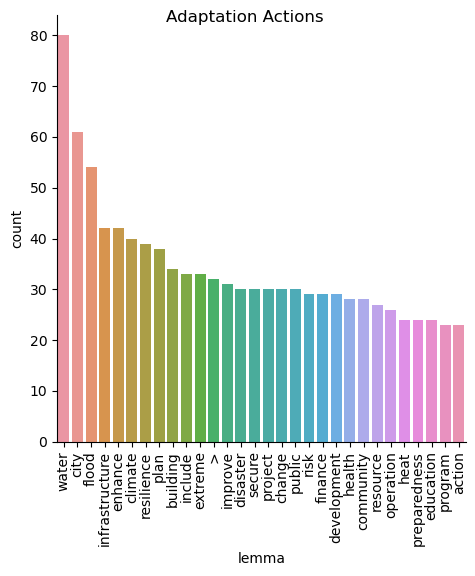

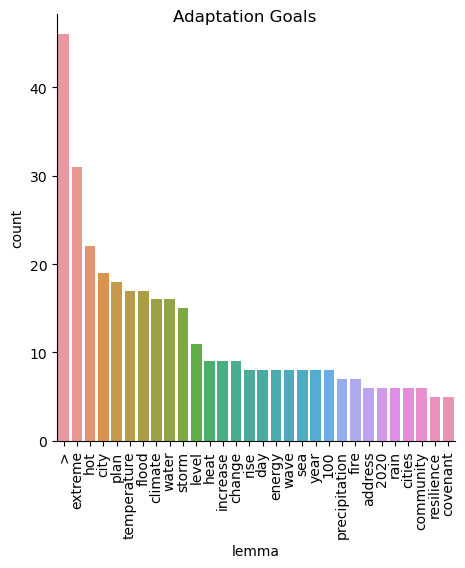

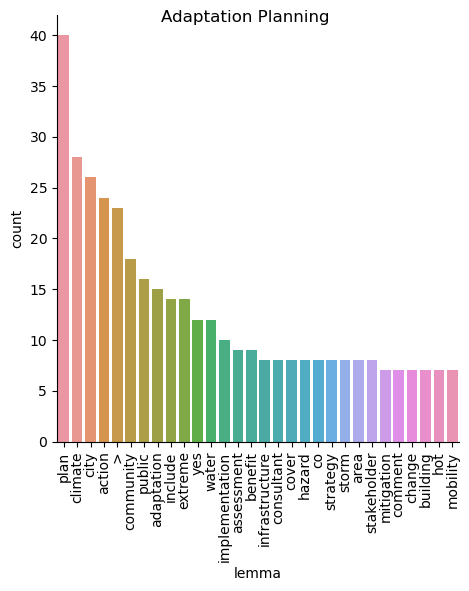

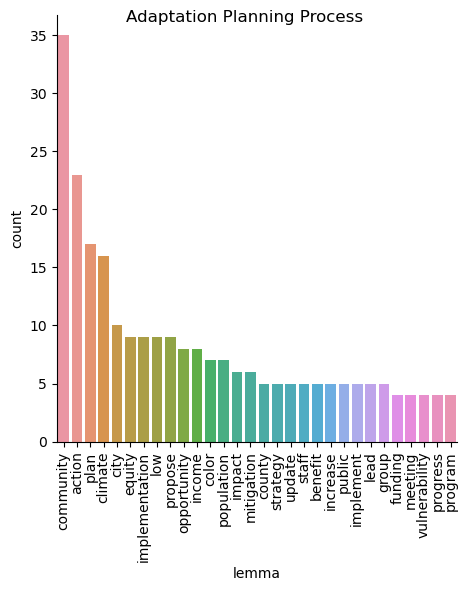

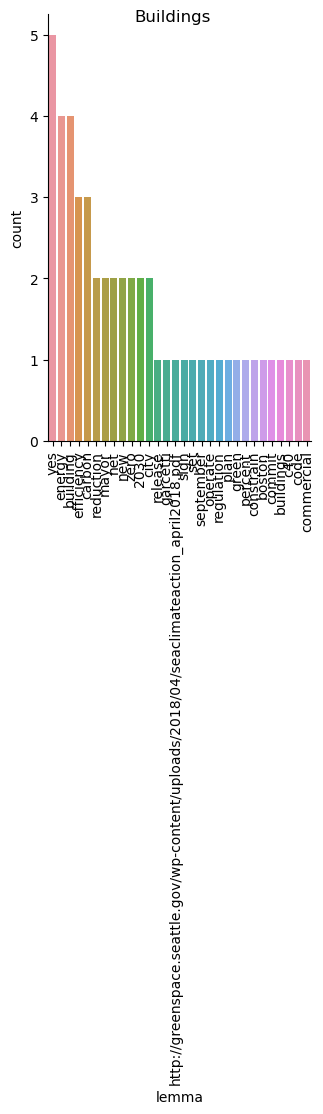

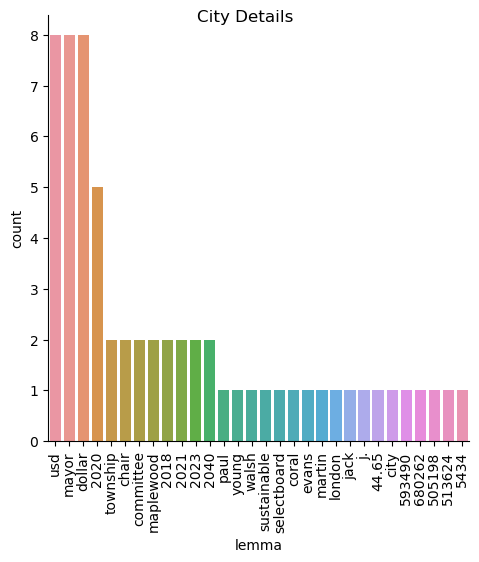

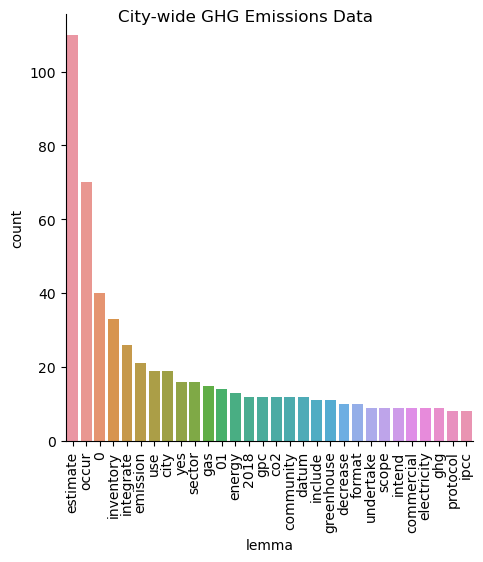

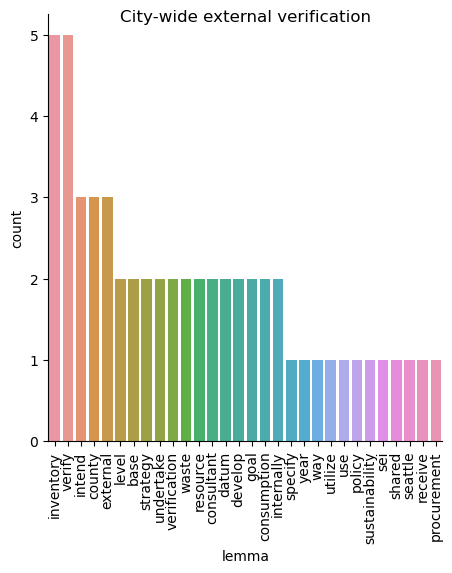

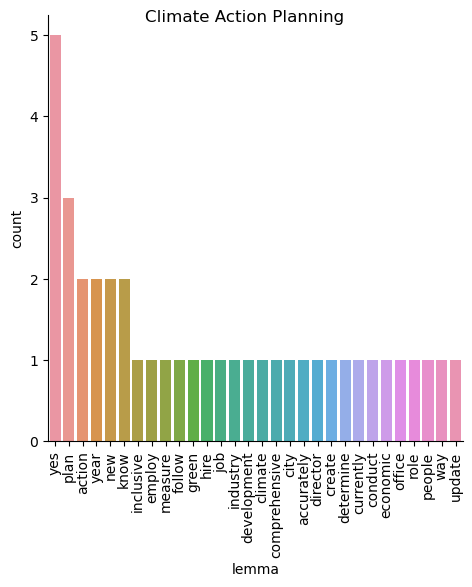

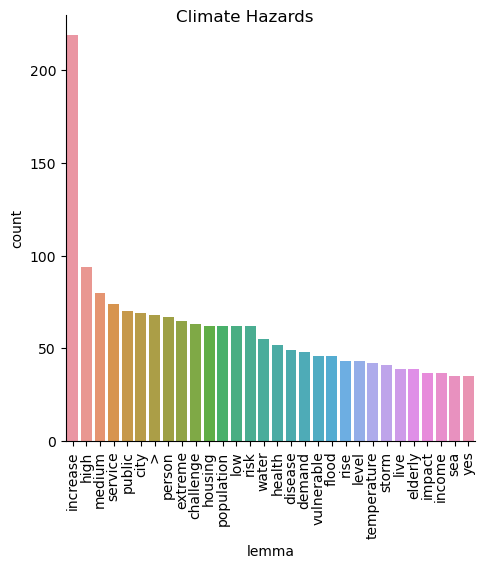

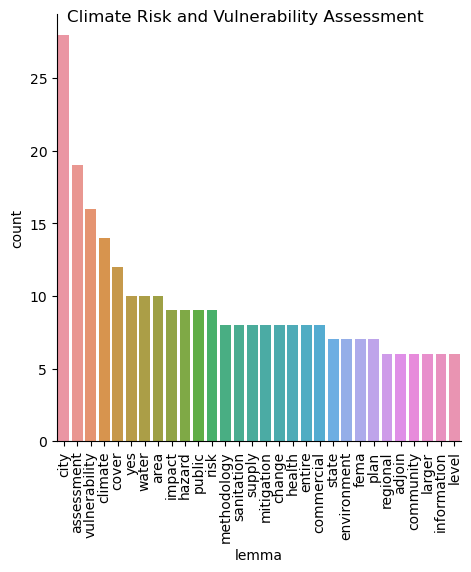

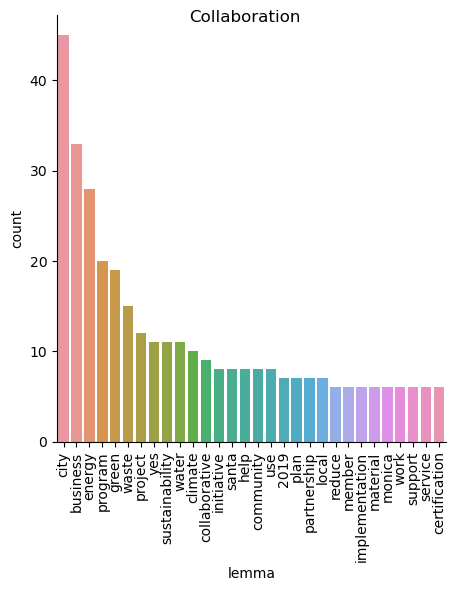

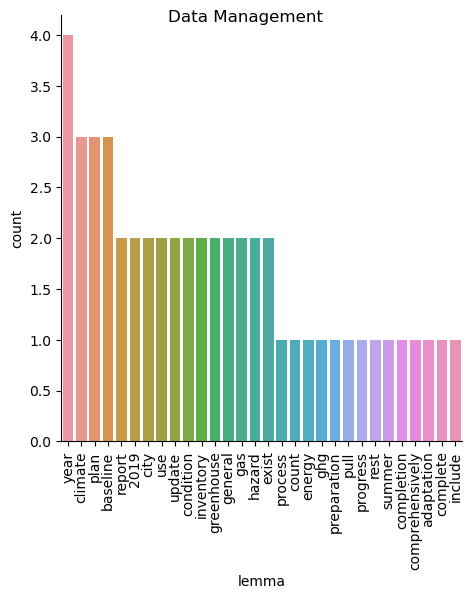

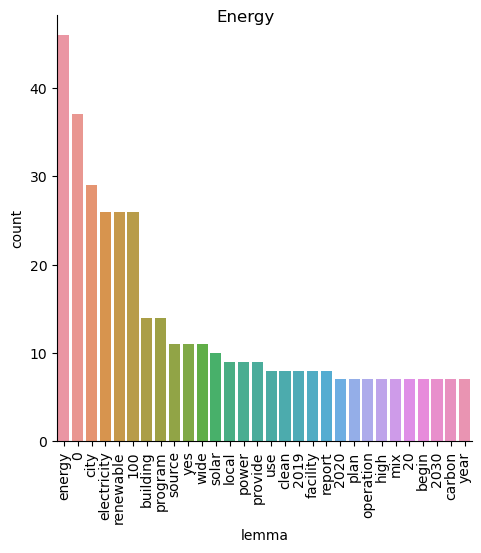

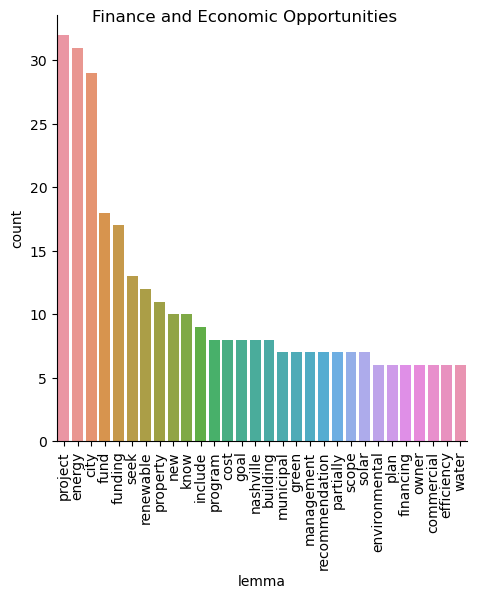

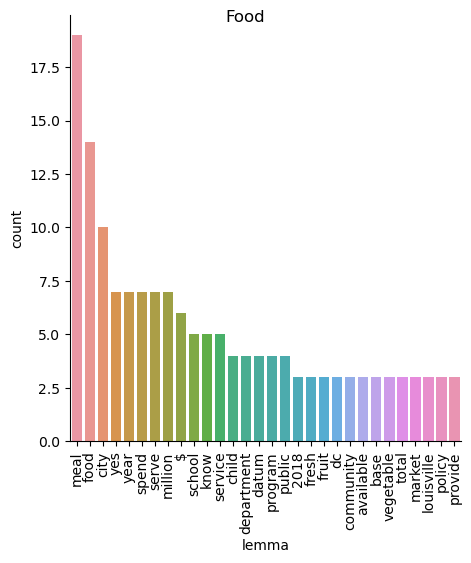

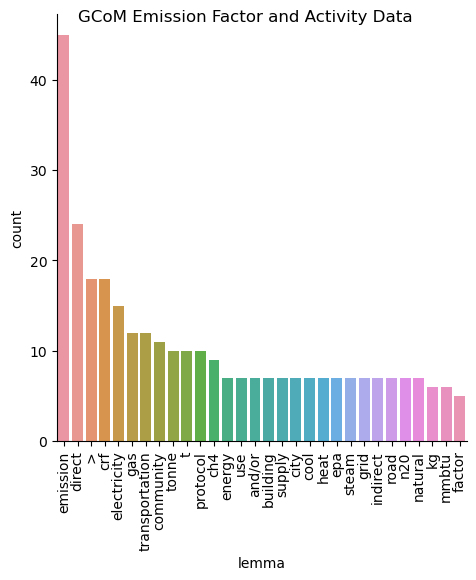

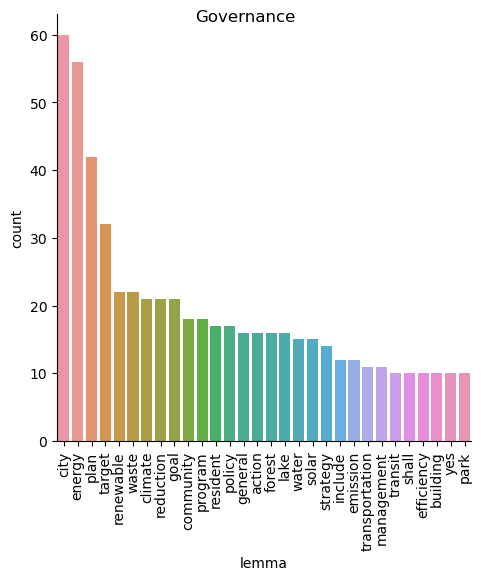

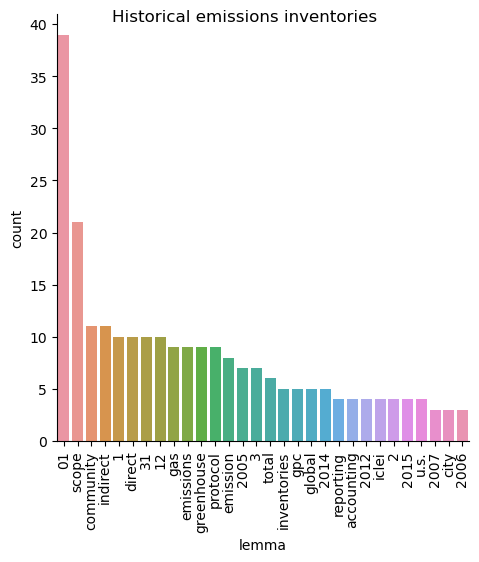

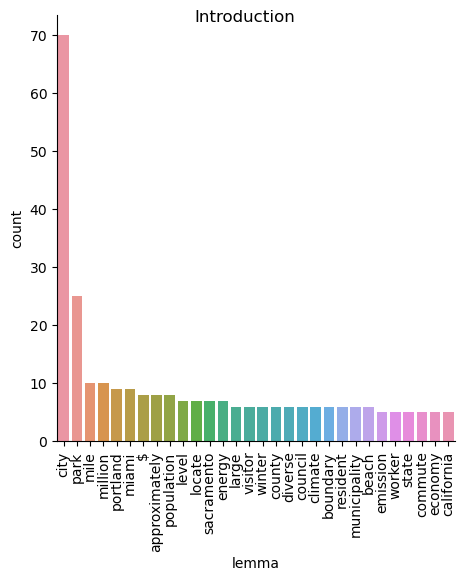

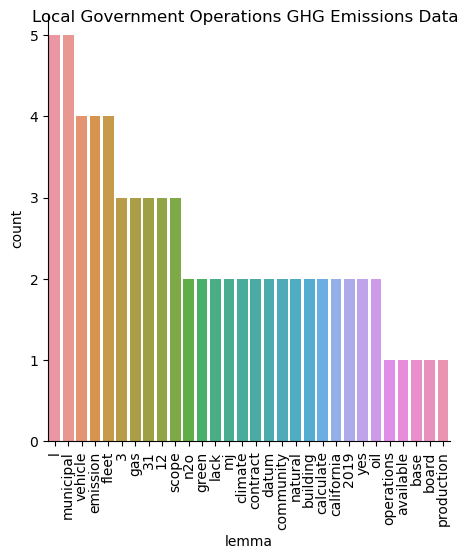

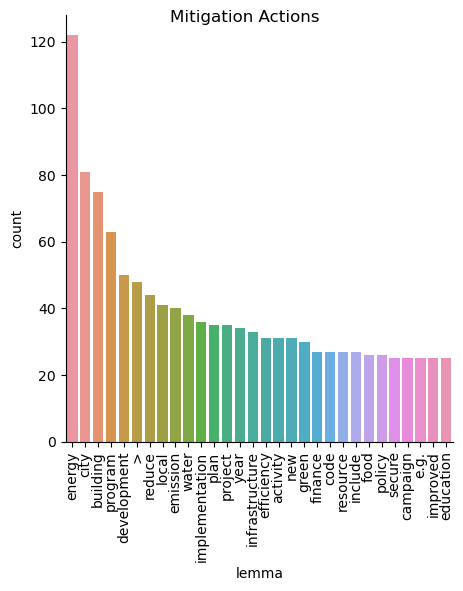

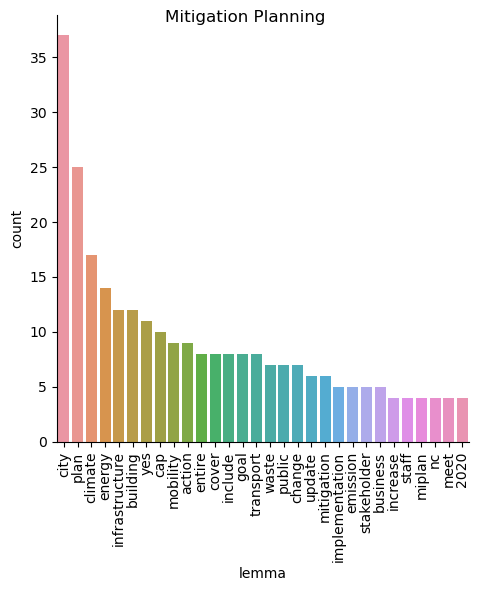

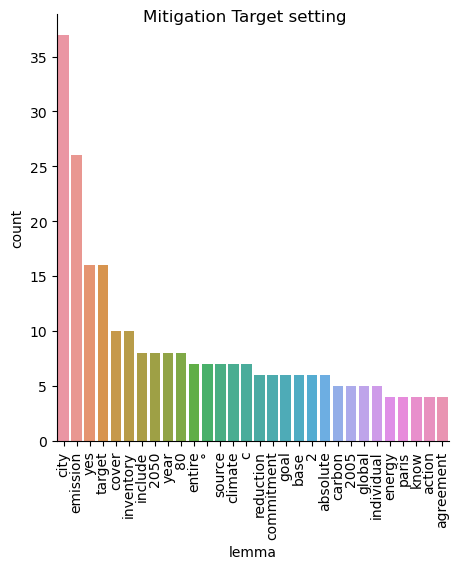

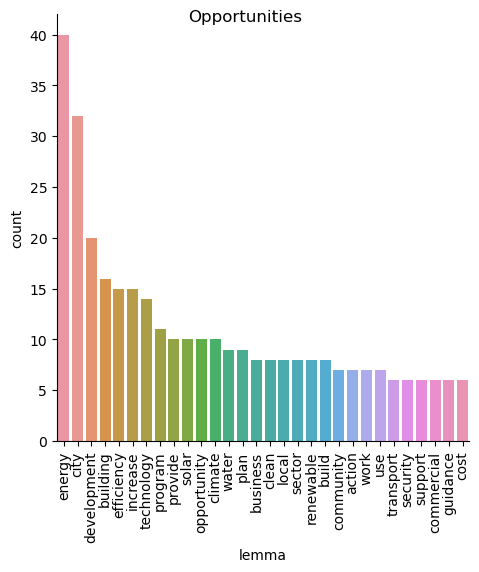

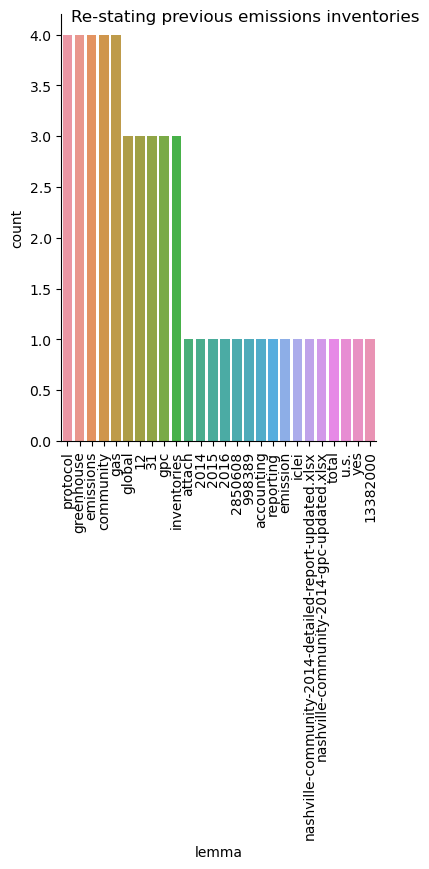

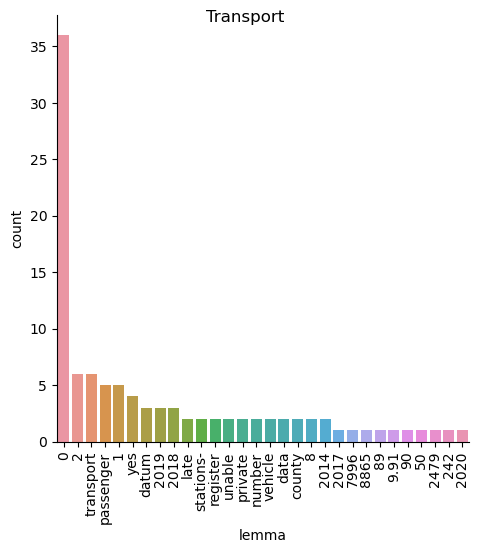

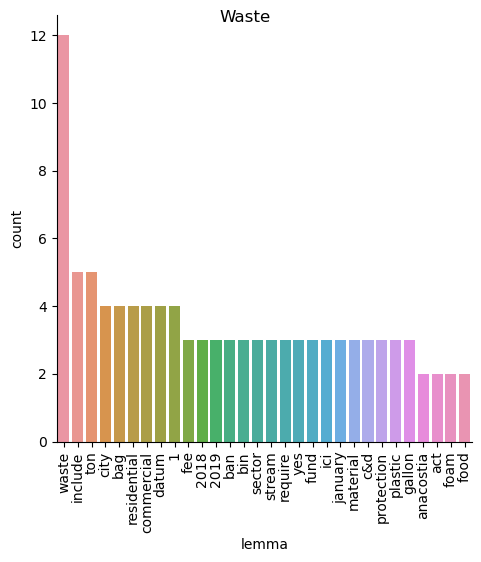

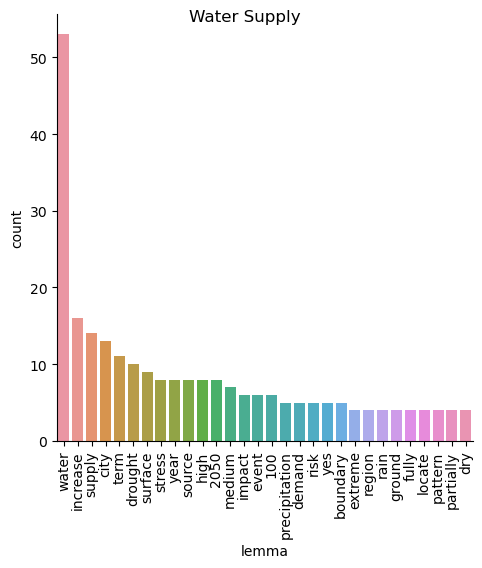

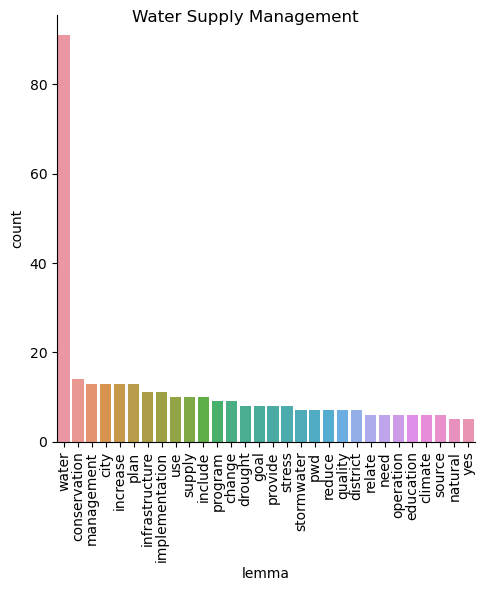

In [62]:
#Counts of top 30 lemma by subsector- graphs (just show 30 )

#for each section, create a plot
for sect in lemma_counts_grouped_w_rank_30.Sect.unique():
    
    #bar plot
    p=sns.catplot(kind='bar',\
                  data=lemma_counts_grouped_w_rank.loc[lemma_counts_grouped_w_rank.Sect==sect].sort_values("count",ascending=False).head(30),
                  x='lemma',
                  y='count')
    p.fig.suptitle(sect)
    p.set_xticklabels(rotation=90)
plt.show()

### We now have most common words per sector

In [63]:
#lets compress the data frame. for each sector, create a list of the lemmas
lemma_counts_grouped_w_rank_30_list = lemma_counts_grouped_w_rank_30.groupby('Sect')['lemma'].apply(list)

#turn it into a DF
lemma_counts_grouped_w_rank_30_list=pd.DataFrame(lemma_counts_grouped_w_rank_30_list).reset_index()
lemma_counts_grouped_w_rank_30_list.columns=['Sect','Common_Words']
lemma_counts_grouped_w_rank_30_list.head(10)

Sect  \
0               Adaptation Actions   
1                 Adaptation Goals   
2              Adaptation Planning   
3      Adaptation Planning Process   
4                        Buildings   
5                     City Details   
6     City-wide GHG Emissions Data   
7  City-wide external verification   
8          Climate Action Planning   
9                  Climate Hazards   

                                        Common_Words  
0  [water, city, flood, infrastructure, enhance, ...  
1  [>, extreme, hot, city, plan, temperature, flo...  
2  [plan, climate, city, action, >, community, pu...  
3  [community, action, plan, climate, city, equit...  
4  [yes, building, energy, efficiency, carbon, ci...  
5  [usd, dollar, mayor, 2020, 2040, 2023, 2021, 2...  
6  [estimate, occur, 0, inventory, integrate, emi...  
7  [inventory, verify, intend, county, external, ...  
8  [yes, plan, action, year, new, know, study, su...  
9  [increase, high, medium, service, public, city...

### Lets find the proportion of words per doc_id that are in the list

In [64]:
#create dataframe of the two tables to include common_words to the list
merged_df = pd.merge(data_sect_id_pos_lemma,lemma_counts_grouped_w_rank_30_list,on='Sect')
merged_df

Sect  doc_id    pos       lemma  \
0           Adaptation Actions       1   NOUN   awareness   
1           Adaptation Actions       1   NOUN     program   
2           Adaptation Actions       1   NOUN    campaign   
3           Adaptation Actions       1   VERB       raise   
4           Adaptation Actions       7   NOUN  resilience   
...                        ...     ...    ...         ...   
33992  Water Supply Management    4975  PROPN       water   
33993  Water Supply Management    4975  PROPN  wastewater   
33994  Water Supply Management    4975   VERB      search   
33995  Water Supply Management    4975   VERB   diversify   
33996  Water Supply Management    4991    NUM        2018   

                                            Common_Words  
0      [water, city, flood, infrastructure, enhance, ...  
1      [water, city, flood, infrastructure, enhance, ...  
2      [water, city, flood, infrastructure, enhance, ...  
3      [water, city, flood, infrastructure, enhance, ...  
4      [water, city, flood, infrastructure, enhance, ...  
...                                                  ...  
33992  [water, conservation, management, city, increa...  
33993  [water, conservation, management, city, increa...  
33994  [water, conservation, management, city, increa...  
33995  [water, conservation, management, city, increa...  
33996  [water, conservation, management, city, increa...  

[33997 rows x 5 columns]

In [65]:
#If lemma is in common_words, return true, else false
merged_df['In']=merged_df.apply(lambda row: row['lemma'] in row['Common_Words'],axis=1)
merged_df.head()

Sect  doc_id   pos       lemma  \
0  Adaptation Actions       1  NOUN   awareness   
1  Adaptation Actions       1  NOUN     program   
2  Adaptation Actions       1  NOUN    campaign   
3  Adaptation Actions       1  VERB       raise   
4  Adaptation Actions       7  NOUN  resilience   

                                        Common_Words    In  
0  [water, city, flood, infrastructure, enhance, ...  True  
1  [water, city, flood, infrastructure, enhance, ...  True  
2  [water, city, flood, infrastructure, enhance, ...  True  
3  [water, city, flood, infrastructure, enhance, ...  True  
4  [water, city, flood, infrastructure, enhance, ...  True

In [66]:
#create a temp table that adds up the "In" column and dividides by total number of "In" rows per dic_id
temp_merge = merged_df.groupby(['Sect','doc_id'],as_index=False).agg(Words_In_List = ('In','sum'),Total_Words=('In','count'))
temp_merge['Word_Proportion']= temp_merge['Words_In_List']/ temp_merge['Total_Words']
final_merge=temp_merge[['Sect','doc_id','Word_Proportion']]
final_merge

Sect  doc_id  Word_Proportion
0          Adaptation Actions       1              1.0
1          Adaptation Actions       7              1.0
2          Adaptation Actions      35              1.0
3          Adaptation Actions      64              1.0
4          Adaptation Actions      68              1.0
...                       ...     ...              ...
4881  Water Supply Management    4784              1.0
4882  Water Supply Management    4899              1.0
4883  Water Supply Management    4956              1.0
4884  Water Supply Management    4975              1.0
4885  Water Supply Management    4991              1.0

[4886 rows x 3 columns]

### Next Steps: Sum up the questions for each section. Perform Clustering on each account_num

In [67]:
#create a temp table that adds up the "In" column and dividides by total number of "In" rows per dic_id
temp_merge = merged_df.groupby(['Sect','doc_id'],as_index=False).agg(Words_In_List = ('In','sum'),Total_Words=('In','count'))
temp_merge['Word_Proportion']= temp_merge['Words_In_List']/ temp_merge['Total_Words']
final_merge=temp_merge[['Sect','doc_id','Word_Proportion']]
final_merge.head()

Sect  doc_id  Word_Proportion
0  Adaptation Actions       1              1.0
1  Adaptation Actions       7              1.0
2  Adaptation Actions      35              1.0
3  Adaptation Actions      64              1.0
4  Adaptation Actions      68              1.0

In [68]:
#join to expand doc_id into account_num and question_ID
df_merge_by_sect = pd.merge(final_merge,us_data_sample[['index','Account_Num','Question_ID']],\
         left_on='doc_id',right_on='index')\
[['Account_Num','Question_ID','Sect','Word_Proportion']]

#average the word_proportion for each sector/Account_Num 
df_merge_by_sect.groupby(['Account_Num','Sect'],as_index=False)['Word_Proportion'].mean()

Account_Num                          Sect  Word_Proportion
0            1184            Adaptation Actions         0.819444
1            1184              Adaptation Goals         1.000000
2            1184   Adaptation Planning Process         1.000000
3            1184                     Buildings         1.000000
4            1184  City-wide GHG Emissions Data         1.000000
...           ...                           ...              ...
1418       841964                        Energy         1.000000
1419       841964            Mitigation Actions         0.561728
1420       841964     Mitigation Target setting         1.000000
1421       841964                 Opportunities         1.000000
1422       841964                  Water Supply         1.000000

[1423 rows x 3 columns]

Once again; hard to find any sort of clusters here. 

## Analysis 2. Use SpaCY vectorizer to cluster the data

In [69]:
#Subset the Fact table for only data from the US for 2020 and remove rows where the answer was NA
us_data = pd.merge(FACT_df,dim_cd_df[['Account_Num','Country','geometry']],on='Account_Num')
us_data.drop_duplicates(inplace=True)
us_data=us_data.query("Country == 'United States of America' & Year ==2020 & Answer != 'Question not applicable'")

In [70]:
#merge with dim_qq_df for the question section
us_data = pd.merge(us_data,dim_qq_df[['Question_ID','Sect']],on='Question_ID')

In [71]:
#sample 5000 rows
us_data_sample = us_data.sample(5000).reset_index(drop=True)
us_data_sample.head()

Account_Num  Year  Question_ID  \
0        31090  2020        21015   
1        43905  2020        21248   
2        53921  2020         8298   
3        31108  2020         8058   
4        59631  2020         5583   

                                              Answer  \
0                                                5.2   
1                                                  0   
2  The goal of this project is to build capacity ...   
3                               Greening the economy   
4                                               High   

                    Country                  geometry                Sect  
0  United States of America  POINT (-77.0369 38.9072)              Energy  
1  United States of America  POINT (-98.4936 29.4241)              Energy  
2  United States of America   POINT (-111.94 33.4255)  Adaptation Actions  
3  United States of America  POINT (-95.3694 29.7602)  Adaptation Actions  
4  United States of America  POINT (-122.156 37.7249)     Climate Hazards

In [72]:
#Check the Sect. We may want to remove a few of the 'boring sectors from the analysis'
us_sect_mask = us_data_sample.groupby('Sect')['Question_ID'].count().sort_values(ascending=False)
us_sect_mask

Sect
Climate Hazards                                   1101
Adaptation Actions                                 670
Mitigation Actions                                 590
City-wide GHG Emissions Data                       455
Energy                                             228
GCoM Emission Factor and Activity Data             180
Mitigation Target setting                          153
Adaptation Planning                                153
Climate Risk and Vulnerability Assessment          150
Finance and Economic Opportunities                 143
Transport                                          138
Mitigation Planning                                118
Adaptation Goals                                   112
Water Supply Management                            108
Historical emissions inventories                   108
Water Supply                                        88
Opportunities                                       72
Governance                                          65
City 

we will subset for sectors with atleast 18 rows of answers (City-wide external verification and greater)

In [73]:
us_sect_mask = us_sect_mask.loc[us_sect_mask.values>17].index
us_data_sample=us_data_sample.loc[us_data_sample.Sect.isin(us_sect_mask)]
us_data_sample

Account_Num  Year  Question_ID  \
0           31090  2020        21015   
1           43905  2020        21248   
2           53921  2020         8298   
3           31108  2020         8058   
4           59631  2020         5583   
...           ...   ...          ...   
4995        58531  2020        12907   
4996        35874  2020        10483   
4997        32550  2020        16643   
4998        49339  2020         7570   
4999        59535  2020         9566   

                                                 Answer  \
0                                                   5.2   
1                                                     0   
2     The goal of this project is to build capacity ...   
3                                  Greening the economy   
4                                                  High   
...                                                 ...   
4995                                               IPCC   
4996  Through the Reimagine Phoenix initiative, the ...   
4997                                                  0   
4998  Incorporating climate change into long-term pl...   
4999                                         Consultant   

                       Country                  geometry  \
0     United States of America  POINT (-77.0369 38.9072)   
1     United States of America  POINT (-98.4936 29.4241)   
2     United States of America   POINT (-111.94 33.4255)   
3     United States of America  POINT (-95.3694 29.7602)   
4     United States of America  POINT (-122.156 37.7249)   
...                        ...                       ...   
4995  United States of America  POINT (-71.0826 42.3934)   
4996  United States of America  POINT (-112.074 33.4484)   
4997  United States of America  POINT (-104.985 39.7376)   
4998  United States of America      POINT (157.59 21.28)   
4999  United States of America  POINT (-106.374 39.6403)   

                                 Sect  
0                              Energy  
1                              Energy  
2                  Adaptation Actions  
3                  Adaptation Actions  
4                     Climate Hazards  
...                               ...  
4995     City-wide GHG Emissions Data  
4996  City-wide external verification  
4997               Mitigation Actions  
4998               Adaptation Actions  
4999              Adaptation Planning  

[4944 rows x 7 columns]

In [74]:
#Create a corpus of Answers
doc = list(nlp.pipe(us_data_sample.Answer))

In [75]:
#vectorize it
vectors=[tokens.vector for tokens in doc]

In [76]:
#isometric mapping

### Step 1 - Configure the Isomap function, note we use default hyperparameter values in this example
embed3 = Isomap(
    n_neighbors=5, # default=5, algorithm finds local structures based on the nearest neighbors
    n_components=3, # number of dimensions
    eigen_solver='auto', # {‘auto’, ‘arpack’, ‘dense’}, default=’auto’
    tol=0, # default=0, Convergence tolerance passed to arpack or lobpcg. not used if eigen_solver == ‘dense’.
    max_iter=None, # default=None, Maximum number of iterations for the arpack solver. not used if eigen_solver == ‘dense’.
    path_method='auto', # {‘auto’, ‘FW’, ‘D’}, default=’auto’, Method to use in finding shortest path.
    neighbors_algorithm='auto', # neighbors_algorithm{‘auto’, ‘brute’, ‘kd_tree’, ‘ball_tree’}, default=’auto’
    n_jobs=-1, # n_jobsint or None, default=None, The number of parallel jobs to run. -1 means using all processors
    metric='minkowski', # string, or callable, default=”minkowski”
    p=2, # default=2, Parameter for the Minkowski metric. When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2
    metric_params=None # default=None, Additional keyword arguments for the metric function.
)

### Step 2 - Fit the data and transform it, so we have 3 dimensions instead of 64
X_trans3 = embed3.fit_transform(vectors)
    
### Step 3 - Print shape to test
print('The new shape of X: ',X_trans3.shape)

The new shape of X:  (4944, 3)


In [77]:
y=us_data_sample.Sect
y.shape

(4944,)

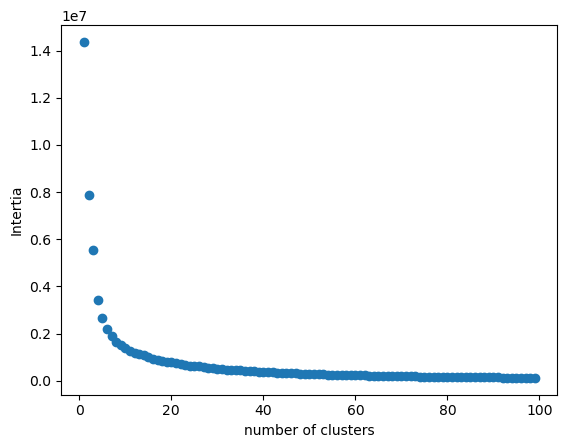

In [80]:
#Elbow plot to determine k neighbrs
x_cols = np.array(X_trans3)
inertia = []

Ks=range(1,100)

for k in Ks:
    model = KMeans(n_clusters = k)
    model.fit(x_cols)
    inertia.append(model.inertia_)

plt.scatter(Ks,inertia)
plt.xlabel("number of clusters")
plt.ylabel("Intertia")
plt.show()

In [81]:
#Create our KMEANS model but with 10 clusters
model = KMeans(n_clusters = 10, random_state = 10)
model.fit(x_cols)
labels = model.predict(x_cols)
labels.shape

Account_Num = us_data_sample.Sect.index

#create a table with the cluster_ID added to Account_Num
cluster_df = pd.DataFrame({'Account_Num':Account_Num, 'Cluster ID':labels})
cluster_df


Account_Num  Cluster ID
0               0           8
1               1           0
2               2           4
3               3           9
4               4           2
...           ...         ...
4939         4995           3
4940         4996           4
4941         4997           0
4942         4998           4
4943         4999           1

[4944 rows x 2 columns]

In [82]:
#expand the X,Y,Z
cluster_df['X']=X_trans3[:,0]
cluster_df['Y']=X_trans3[:,1]
cluster_df['Z']=X_trans3[:,2]
cluster_df

Account_Num  Cluster ID          X          Y          Z
0               0           8  34.117898   5.740931  12.976344
1               1           0  98.700796   7.115743 -75.786328
2               2           4 -41.515300 -12.085930 -11.836671
3               3           9   3.079006 -22.407957   2.502606
4               4           2  48.006931  -1.337706   6.700909
...           ...         ...        ...        ...        ...
4939         4995           3 -20.161864 -11.713253  33.773243
4940         4996           4 -43.023190 -11.904077 -13.335579
4941         4997           0  98.700796   7.115743 -75.786328
4942         4998           4 -42.449575 -18.596665  -9.887006
4943         4999           1 -18.709834  12.190869  -4.136466

[4944 rows x 5 columns]

In [83]:
# Create a 3D scatter plot

#article = https://towardsdatascience.com/isomap-embedding-an-awesome-approach-to-non-linear-dimensionality-reduction-fc7efbca47a0
fig = px.scatter_3d(cluster_df, 
                    x='X', 
                    y='Y',
                    z='Z',
                    color='Cluster ID',
                    height=900, width=900
                   )

# Update chart looks
fig.update_layout(#title_text="Scatter 3D Plot",
                  showlegend=True,
                  legend=dict(orientation="h", y=0, xanchor="center", x=0.5),
                  scene_camera=dict(up=dict(x=0, y=0, z=1), 
                                        center=dict(x=0, y=0, z=-0.2),
                                        eye=dict(x=-1.5, y=1.5, z=0.5)),
                                        margin=dict(l=0, r=0, b=0, t=0),
                  scene = dict(xaxis=dict(backgroundcolor='white',
                                          color='black',
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                         ),
                               yaxis=dict(backgroundcolor='white',
                                          color='black',
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                          ),
                               zaxis=dict(backgroundcolor='lightgrey',
                                          color='black', 
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                         )))

# Update marker size
fig.update_traces(marker=dict(size=2))

fig.show()

In [84]:
# Create another scatter plot but this time have the color based off sectors. 
## NOTE. DOUBLE CLICK ON THE LABEL FOR 'CLIMATE HAZARDS' and you'll see two (maybe 3) distinct GROUPINGS
fig = px.scatter_3d(cluster_df, 
                   x='X', 
                    y='Y',
                    z='Z',
                    color=y.astype(str),
                    height=900, width=900
                   )

# Update chart looks
fig.update_layout(#title_text="Scatter 3D Plot",
                  showlegend=True,
                  legend=dict(orientation="h", y=0, xanchor="center", x=0.5),
                  scene_camera=dict(up=dict(x=0, y=0, z=1), 
                                        center=dict(x=0, y=0, z=-0.2),
                                        eye=dict(x=-1.5, y=1.5, z=0.5)),
                                        margin=dict(l=0, r=0, b=0, t=0),
                  scene = dict(xaxis=dict(backgroundcolor='white',
                                          color='black',
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                         ),
                               yaxis=dict(backgroundcolor='white',
                                          color='black',
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                          ),
                               zaxis=dict(backgroundcolor='lightgrey',
                                          color='black', 
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                         )))

# Update marker size
fig.update_traces(marker=dict(size=2))

fig.show()

##### 

In [85]:
## Analysis 3: Create unique colors of the graph above for Sector and Cluster

In [86]:
#dict to hold transformed vectors 
rows = []

for sector in us_data_sample.Sect.unique():
    #subset the data
    data = us_data_sample.loc[us_data_sample.Sect==sector]

    #nlp
    doc = list(nlp.pipe(data.Answer))
    
    #vectorize
    vectors=[tokens.vector for tokens in doc]
    
    #embed
    iso = Isomap(
    n_neighbors=5, # default=5, algorithm finds local structures based on the nearest neighbors
    n_components=3, # number of dimensions
    eigen_solver='auto', # {‘auto’, ‘arpack’, ‘dense’}, default=’auto’
    tol=0, # default=0, Convergence tolerance passed to arpack or lobpcg. not used if eigen_solver == ‘dense’.
    max_iter=None, # default=None, Maximum number of iterations for the arpack solver. not used if eigen_solver == ‘dense’.
    path_method='auto', # {‘auto’, ‘FW’, ‘D’}, default=’auto’, Method to use in finding shortest path.
    neighbors_algorithm='auto', # neighbors_algorithm{‘auto’, ‘brute’, ‘kd_tree’, ‘ball_tree’}, default=’auto’
    n_jobs=-1, # n_jobsint or None, default=None, The number of parallel jobs to run. -1 means using all processors
    metric='minkowski', # string, or callable, default=”minkowski”
    p=2, # default=2, Parameter for the Minkowski metric. When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2
    metric_params=None # default=None, Additional keyword arguments for the metric function.
)
    X_trans = iso.fit_transform(vectors)
    

    model = KMeans(n_clusters = 3, random_state = 10)
    model.fit(X_trans)
    labels = model.predict(X_trans)
    
    
    # create a row dictionary for each value in X_trans
    for i in range(len(X_trans)):
        row = {
            'Account_Num': data.iloc[i]['Account_Num'],
            'Sector': sector,
            'X_trans': X_trans[i],
            'Label':labels[i]
        }
        rows.append(row)

# create a pandas DataFrame from the rows list
df = pd.DataFrame(rows)

df['X']=[arr[0] for arr in df.X_trans]
df['Y'] = [arr[1] for arr in df.X_trans]
df['Z'] = [arr[2] for arr in df.X_trans]
df.Label=df.Label.astype('str')
df['Sector-Label']= df['Sector']+'-'+df['Label']
df.sort_values(['Account_Num','Sector'])



Account_Num                                     Sector  \
247          1184                         Adaptation Actions   
288          1184                         Adaptation Actions   
308          1184                         Adaptation Actions   
381          1184                         Adaptation Actions   
501          1184                         Adaptation Actions   
...           ...                                        ...   
1897       841964                            Climate Hazards   
1936       841964                            Climate Hazards   
3648       841964  Climate Risk and Vulnerability Assessment   
75         841964                                     Energy   
105        841964                                     Energy   

                                                X_trans Label           X  \
247   [4.115968233190504, 15.267955031777282, -60.50...     2    4.115968   
288   [-14.236701673624337, -31.938538288697277, -19...     2  -14.236702   
308   [-61.86509788938553, -4.502719845827473, 35.98...     0  -61.865098   
381   [-27.615303827482453, -34.97436692759947, 15.8...     2  -27.615304   
501   [233.98454404211824, 30.749858565728925, 17.58...     1  233.984544   
...                                                 ...   ...         ...   
1897  [12.19354878403254, 4.261530797498668, 1.61989...     0   12.193549   
1936  [-72.32325838008528, 137.1124158200117, -0.404...     2  -72.323258   
3648  [-51.481188525238764, -6.017053873324714, -6.2...     1  -51.481189   
75    [20.64347764332303, -79.94225786931001, -33.87...     0   20.643478   
105   [-67.31868776704964, -55.48872022205307, 78.28...     0  -67.318688   

               Y          Z                                 Sector-Label  
247    15.267955 -60.506872                         Adaptation Actions-2  
288   -31.938538 -19.811316                         Adaptation Actions-2  
308    -4.502720  35.986540                         Adaptation Actions-0  
381   -34.974367  15.848219                         Adaptation Actions-2  
501    30.749859  17.584511                         Adaptation Actions-1  
...          ...        ...                                          ...  
1897    4.261531   1.619898                            Climate Hazards-0  
1936  137.112416  -0.404735                            Climate Hazards-2  
3648   -6.017054  -6.220611  Climate Risk and Vulnerability Assessment-1  
75    -79.942258 -33.873775                                     Energy-0  
105   -55.488720  78.289307                                     Energy-0  

[4944 rows x 8 columns]

In [88]:
# Create a 3D scatter plot
fig = px.scatter_3d(df, 
                    x = 'X',
                    y = 'Y',
                    z = 'Z',
                    color='Sector-Label',
                    height=900, width=900
                   )

# Update chart looks
fig.update_layout(#title_text="Scatter 3D Plot",
                  showlegend=True,
                  legend=dict(orientation="h", y=0, xanchor="center", x=0.5, traceorder="normal"),
                  scene_camera=dict(up=dict(x=0, y=0, z=1), 
                                        center=dict(x=0, y=0, z=-0.2),
                                        eye=dict(x=-1.5, y=1.5, z=0.5)),
                                        margin=dict(l=0, r=0, b=0, t=0),
                  scene = dict(xaxis=dict(backgroundcolor='white',
                                          color='black',
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                         ),
                               yaxis=dict(backgroundcolor='white',
                                          color='black',
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                          ),
                               zaxis=dict(backgroundcolor='lightgrey',
                                          color='black', 
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                         )))
# Update marker size
fig.update_traces(marker=dict(size=2))

fig.show()

Double click on Climate Hazards-0, Climate Hazards-1, and Climate Hazards-2. You'll see the groupings

## Analysis 4: Can we view these groupings on a map? 

In [89]:
#isolate dataframe to investigate climate hazards
climate_hazard_df = df.query("Sector=='Climate Hazards'")[['Account_Num','Label']].sort_values('Account_Num')

In [90]:
#merge with dim_cd_df to get the lat/ long
climate_hazard_df=climate_hazard_df.merge(dim_cd_df.query("Reporting_Year==2020")[['Account_Num','lat','long']],on='Account_Num',how='left')
climate_hazard_df

Account_Num Label      lat     long
0            1184     0  30.2672 -97.7431
1            1184     0  30.2672 -97.7431
2            1184     0  30.2672 -97.7431
3            1184     0  30.2672 -97.7431
4            1184     0  30.2672 -97.7431
...           ...   ...      ...      ...
1096       841964     0  25.9812 -80.1484
1097       841964     0  25.9812 -80.1484
1098       841964     0  25.9812 -80.1484
1099       841964     0  25.9812 -80.1484
1100       841964     0  25.9812 -80.1484

[1101 rows x 4 columns]

In [93]:
#Each account_Number may have several clustering lables. Lets find out which label is most common per account

#print out the counts for each label per account_Num
climate_hazard_df_counts=climate_hazard_df.groupby(['Account_Num','lat','long'],as_index=False)['Label'].value_counts()


#create our mask that we'll use to filter our data
mask = climate_hazard_df_counts.groupby('Account_Num',as_index=False)['count'].max()

#merge on mask and climate_hazard_df_counts to line up account_Num and counts
main_label_df = climate_hazard_df_counts.merge(mask,on=['Account_Num','count'])

main_label_df

Account_Num      lat      long Label  count
0           1184  30.2672  -97.7431     0     17
1           3203  41.8781  -87.6298     0      8
2           3417  40.7128  -74.0059     0     10
3          10495  36.1699 -115.1400     0      9
4          10894  34.0522 -118.2440     0      5
..           ...      ...       ...   ...    ...
109        74508  44.0554  -91.6663     0      7
110        74531  35.5000 -106.0000     0     10
111        74594  26.4986  -80.2160     0     10
112       832838  41.9305  -70.0310     0      9
113       841964  25.9812  -80.1484     0     10

[114 rows x 5 columns]

In [94]:
#Create a map of clusters around the US
import folium
#Create a map
map1 = folium.Map(
    tiles='cartodbpositron',
    zoom_start=100)

def set_marker_color(row):
    if row["Label"] == '0':
        return "blue"
    elif row["Label"] == '1':
        return "red"
    elif row["Label"] == '2':
        return "green"
    else:
        return "gray"

main_label_df.apply(lambda row:folium.CircleMarker(radius=3,location=[row["lat"], row["long"]],fill=False,color=set_marker_color(row)).add_to(map1),axis=1)

map1